In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.530258 -1.678320 -0.295959 -0.287776  0.540818  0.938386 -0.177778   
  1   0.368612 -0.214640 -0.179991  0.461715  1.068456 -0.031743  0.192684   
  2   0.140952 -0.794422 -0.421460 -1.337142  0.070613 -0.194337 -0.108947   
  3   0.288669 -0.347913  0.304510  0.264070 -0.519462  0.025062  0.550824   
  4   0.360170 -0.809165 -1.281183 -0.034764  1.001831  0.412258  1.004991   
  5  -0.532458 -1.221529 -0.491781 -0.630034  0.319559 -0.292886  0.032942   
  6   0.736269 -0.092138  0.382214  0.892402  0.866007 -1.307200 -0.305592   
  7   0.459697  0.120435 -0.380333  0.015861 -0.077645 -0.701102 -0.273768   
  8   0.746301 -0.029679  0.756962  1.032896  0.517344  0.304785  0.717454   
  9  -0.945109 -0.241131  0.087170  0.676255  0.706763  1.010568  0.515870   
  10  1.113080 -1.496586 -1.226660 -0.135097  0.094947  0.120175 -0.198820   
  11  0.858226 -0.606829  0.536933  0.291311  1.288057 -0.130578 -0.165323   
  12  0.019655 -0.115827 -0.188833 -1.806358  0.285062  0.316200 -0.158504   
  13 -1.119585 -1.033022 -0.349994  0.040224  0.301635 -0.003820 -0.083380   
  14  0.736537 -0.090449 -0.527532 -0.549981  1.293321 -0.053485 -0.463937   
  15  0.071492 -0.336410  0.107255 -0.641807  0.125442  0.275153  0.342314   
  16  0.505951  0.411638  0.508434  1.034476 -0.778150  0.875532  0.199148   
  17  0.245825 -0.098143  0.308876 -0.733709  0.978579 -0.180189  0.011649   
  18  1.749072  0.175589 -0.003536 -0.675445  0.243604  0.191312  0.045095   
  19 -0.087988 -0.876497  0.367710  0.101214  0.731002 -0.542849 -0.506340   
  20  0.075266 -0.719213 -0.227136 -0.038919 -0.227785 -0.483973 -0.070410   
  21 -1.240762 -1.341981 -1.196234 -0.697378 -0.054507  0.475109  0.009784   
  22 -0.976185 -0.870497 -0.762415 -1.081231 -0.141522 -0.080659 -0.104484   
  23  1.354062  0.025685 -0.599336  0.105558 -0.138417  0.123093  0.124378   
  24  0.485237 -0.604335  0.601687  0.175567  0.552904 -0.385449 -0.590894   
1 0   0.293452 -0.342116 -0.605977 -0.945444 -0.294136 -0.211300  0.723653   
  1   0.009549  1.120056 -0.125711  0.057960  1.108602  0.050477  1.113780   
  2  -1.011667 -0.212905 -1.646215 -0.130896 -0.717951  0.211132 -0.127823   
  3  -0.367360  0.426930  0.518789  1.068362 -0.411851 -0.935469  0.430765   
  4   0.780289  0.444409 -0.478239 -0.669435 -0.851515  0.236803  0.886672   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.434643 -0.442831 -0.196670  ... -0.666431 -0.701714  0.460672   
  1  -0.606107  0.678747 -0.811438  ...  0.496648  0.642547  0.744757   
  2  -0.508124 -0.729074  0.068965  ... -0.717628 -0.626234  0.254173   
  3   0.223344  0.444837  0.184068  ...  0.286103  0.197080 -0.322318   
  4  -0.068745  0.292349  0.423627  ... -0.706938  0.020894  0.467201   
  5  -0.783426 -0.126389 -0.246683  ...  0.470309 -0.680779  0.363358   
  6  -0.728200  0.755652  0.533953  ... -0.174499 -0.483370  0.084019   
  7  -0.451908  0.430234 -0.463236  ...  0.728499  0.121274  0.820220   
  8  -0.118871 -0.138882 -0.123213  ...  0.076616  0.927107 -0.243637   
  9  -0.875423  0.115618 -0.127963  ... -0.160635 -0.375155 -0.137644   
  10 -0.661797  0.064057 -0.468727  ... -0.792012  0.086390 -0.432770   
  11 -0.444381 -0.267786 -0.316884  ...  0.173201  0.731708  0.210030   
  12  0.217952 -0.262702 -0.161658  ...  0.031318  0.072180 -0.374484   
  13 -1.098921  0.518421 -0.262508  ... -1.078477 -0.206587 -0.652170   
  14 -0.617577 -0.476854 -0.674460  ... -0.688646 -0.059425  0.437169   
  15 -0.014250 -0.598711 -0.396214  ... -0.040390 -0.320259 -0.123982   
  16  0.066541 -0.198072 -0.601452  ...  0.183850 -0.109262 -0.730347   
  17 -1.101417  0.098975  0.347489  ... -0.878691 -0.701956 -0.430616   
  18 -0.035956 -0.430163  0.596281  ... -1.398288 -1.043586 -0.846438   
  19 -0.018913  0.233817  0.015186  ... -0.571519 -0.081158  0.017813   
  20 -0.434575  0.283241 -0.232707  ...  0.099265 -0.105832 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.094336  0.035516  30.812663  1.773293e-208  1.024726  1.163945


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



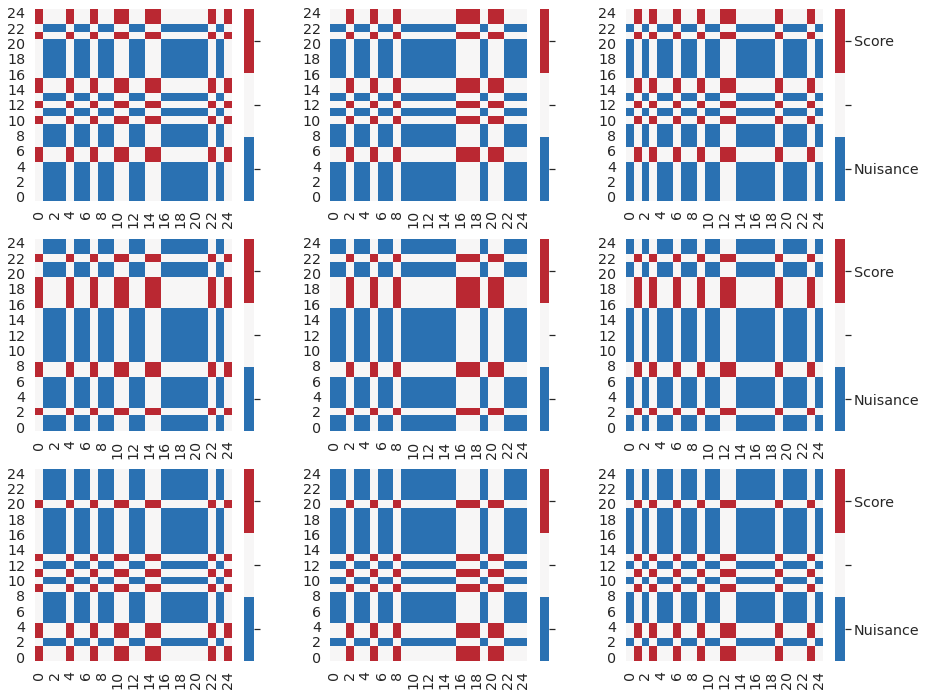

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



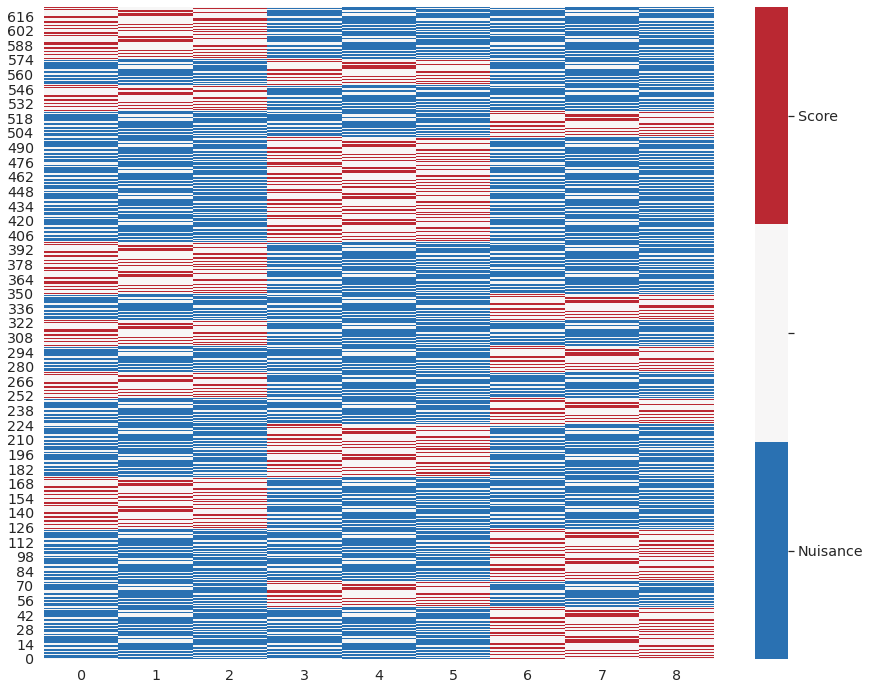

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])